## Analysis

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Impact Of Airline Tweets in the Sentiment Of A Conversation

Dataset of conversations & Dates as downloaded here
https://drive.google.com/open?id=13v22L7LXIElILm2M4vfdfeo9sMjyqIOM

In [2]:
df = pd.read_csv('conversations_with_sentimpact.csv', encoding='ISO-8859-1')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['mean_sentiment'].astype(float, inplace=True).describe()

count    372429.000000
mean          0.542905
std           0.584006
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           2.000000
Name: mean_sentiment, dtype: float64

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,False,conversation_id,raw_tweets_info,conversation_length,tweet_ids,user_ids,airlines_involved,mean_sentiment,sentiments,full_text,dates,SentChange
0,0,0,0,5,"[(747530773037780992, 31132554), (747526794446...",2,"[747526794446802944, 747530773037780992]","[22873368, 31132554]",['No airlines involved'],NaN,"[nan, 1]",['Hey @British_Airways our @easyJet flight Ven...,"['Mon Jun 27 20:27:30 +0000 2016', 'Mon Jun 27...",[]
1,1,1,1,6,"[(747530681509625860, 417945325), (74745123859...",2,"[747451238598475776, 747530681509625860]","[55904765, 417945325]",['No airlines involved'],0.0,"[0, 0]",['@easyJet thanks for looking after my luggage...,"['Mon Jun 27 15:27:16 +0000 2016', 'Mon Jun 27...",[]
2,2,2,2,11,"[(747530531475173376, 597673831), (74752831114...",2,"[747528311144734720, 747530531475173376]","[427951650, 597673831]",['No airlines involved'],0.5,"[1, 0]","[""@British_Airways I booked via Expedia. I'm n...","['Mon Jun 27 20:33:32 +0000 2016', 'Mon Jun 27...",[]
3,3,3,3,12,"[(747530509098450944, 1624311463), (7475297117...",2,"[747529711782244352, 747530509098450944]","[1624311463, 1624311463]",['No airlines involved'],0.0,"[0, 0]",['@easyJet is there anyway to travel with 2 ca...,"['Mon Jun 27 20:39:06 +0000 2016', 'Mon Jun 27...",[]
4,4,4,4,14,"[(747530348561571840, 154605692), (74752081839...",2,"[747520818398232576, 747530348561571840]","[117754884, 154605692]",['No airlines involved'],0.5,"[1, 0]",['@easyJet how nice of you not to reply to my ...,"['Mon Jun 27 20:03:46 +0000 2016', 'Mon Jun 27...",[]


## User sentiment before and after customer support

In [5]:
#helper functions
def append_row(df, entry):
    assert len(df.columns) == len(entry), "Not enough data"
    df2 = pd.DataFrame([entry,], columns=df.columns)
    return df.append(df2, ignore_index=True)

def time_delta(datestring1, datestring2):
    date1 = datetime.datetime.strptime(datestring1, '%a %b %d %H:%M:%S +0000 %Y')
    date2 = datetime.datetime.strptime(datestring2, '%a %b %d %H:%M:%S +0000 %Y')
    timedelta = date2 - date1
    return(timedelta.seconds)

In [13]:
def sentiment_vs_replytime(airline, airline_id, df):
    total = 0
    errors = 0
    
    #filter on specific airline
    if len(airline) == 1:
        df_airline = df[df['airlines_involved'] == f"['{airline[0]}']"]
        print(f"[{airline[0]}]")
        print(df_airline.shape)
    else:
        df_airline = df
    
    df_airline = df_airline[df_airline.astype(str)['SentChange'] != '[]']
    
    df_interaction = pd.DataFrame(columns=['replyTime', 'sentChange'])
    #find interactions
    for data in df_airline[['user_ids', 'sentiments', 'dates', 'SentChange']].values:
        all_ids = eval(data[0])
        sentchange = eval(data[3])
        #sent_change_count = 0
        for i in range(0, len(all_ids)):
            if (str(all_ids[i]) in airline_id) and (len(sentchange)!=0):   
                    try:
                        total += 1
                        date1 = eval(data[2])[i-1]
                        date2 = eval(data[2])[i]
                        replytime = time_delta(date1, date2)

                        sentiment_delta = sentchange[0]
                        del sentchange[0]

                        df_interaction = append_row(df_interaction, [replytime, sentiment_delta])
                    except NameError:
                        errors += 1
                        pass
    
    print('errors: ' + str(errors))
    print('total: ' + str(total))
    return df_interaction

In [14]:
df_klm1 = sentiment_vs_replytime(["KLM"],["56377143"], df)
#df_klm1['replyTime'].describe()
df_klm1['replyTime'] = df_klm1['replyTime'].astype('int64')
df_klm1['sentChange'] = df_klm1['sentChange'].astype('float64')

[KLM]
(37868, 14)
errors: 0
total: 2373


In [42]:
df_ba1 = sentiment_vs_replytime(["British_Airways"],["18332190"], df)
#df_klm1['replyTime'].describe()
df_ba1.shape

[British_Airways]
(68941, 14)
errors: 0
total: 10088


(10088, 2)

# Statistical Analysis

In [47]:
from sklearn.linear_model import LinearRegression  # for linear regression
from scipy import stats
import numpy as np

In [48]:
class LinearRegression(LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [49]:
lr = LinearRegression()
lr.fit(df_klm1[['replyTime']], df_klm1[['sentChange']])
print(lr.coef_[0][0], lr.intercept_)
print(lr.p)

-1.47876206568e-05 0.0
[[  5.74207348e-13]]


In [51]:
df_ba1[]

,replyTime,sentChange
0,13306,0.0
1,38257,-2.0
2,31347,-1.0
3,29186,0.0
4,3160,0.0
5,22664,0.0
6,28025,0.0
7,28265,0.0
8,37971,0.0
9,11525,0.0


In [55]:
lr2 = LinearRegression()
lr2.fit(list(df_ba1[['replyTime']].astype(float).dropna()), list(df_ba1[['sentChange']].dropna()))
lr2.coef_, lr2.intercept_
print(lr2.p)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: could not convert string to float: 'replyTime'

# Visualization

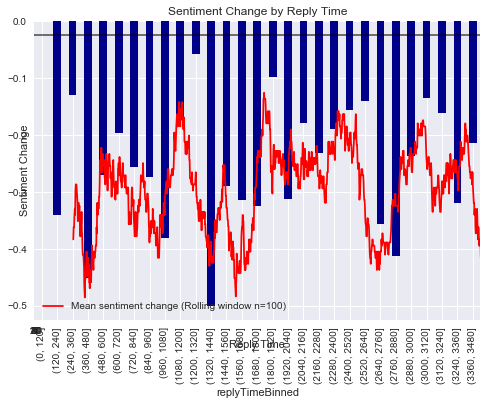

In [12]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

df_klm1['replyTime'] = df_klm1['replyTime'].astype('int64')
df_klm1['sentChange'] = df_klm1['sentChange'].astype('float64')
bins = [120*n for n in range(0, 30)]
df_klm1['replyTimeBinned'] = pd.cut(df_klm1['replyTime'], bins)
klm_grouped = df_klm1.groupby(by='replyTimeBinned')


df_klm2 = df_klm1.sort_values(by='replyTime', ascending=True).rolling(100).mean()
df_klm2 = df_klm2.set_index('replyTime')

df_klm2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)', ax=ax2, grid=False)
klm_grouped['sentChange'].mean().plot(kind='bar', color='darkblue',label='Mean Sentiment Change per ReplyTime', ax=ax)

plt.xticks([])
plt.yticks([])

plt.xlim(0,3600)
plt.xticks([5*n for n in range(0, 6)],[10*n for n in range(0, 6)])
plt.ylabel('Sentiment Change')
plt.xlabel('Reply Time')
plt.title("Sentiment Change by Reply Time")
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower left')
#klm_grouped['sentChange'].count().plot(kind='bar')
plt.show()

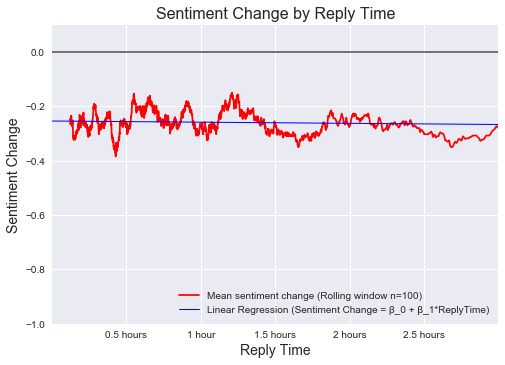

In [13]:
df_klm2 = df_klm1.sort_values(by='replyTime', ascending=True).rolling(200).mean()
df_klm2 = df_klm2.set_index('replyTime')

df_klm2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)')

lr = LinearRegression()
lr.fit(df_klm1[['replyTime']], df_klm1[['sentChange']])
x1 = 0
y1 = lr.intercept_[0]
x2 = 10800
y2 = lr.intercept_[0] + lr.coef_[0][0]*x2
plt.plot([x1, x2], [y1, y2], 'k-', lw=1, label="Linear Regression (Sentiment Change = β_0 + β_1*ReplyTime)", color='blue')

plt.xlim(0,10800)
plt.ylim(-1,0.1)
plt.xticks([1800, 3600, 5400, 7200, 9000], ["0.5 hours", "1 hour", "1.5 hours", "2 hours", "2.5 hours"])
plt.ylabel('Sentiment Change', size=14)
plt.xlabel('Reply Time', size=14)
plt.title("Sentiment Change by Reply Time", size=16)
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower right')
plt.savefig('SentimentChange_by_ReplyTime.png', dpi=300)
plt.show()

In [147]:
airline_names = ["KLM", "AirFrance", "British_Airways", "AmericanAir", "Lufthansa", 
"AirBerlin", "AirBerlin assist", "easyJet", "RyanAir", "SingaporeAir", 
"Qantas", "EtihadAirways", "VirginAtlantic"]
airline_ids = ["56377143", "106062176", "18332190", "22536055", 
"124476322", "26223583", "2182373406", "38676903", 
"1542862735", "253340062", "218730857", "45621423", "20626359"]

df_all = sentiment_vs_replytime(airline_names, airline_ids, df)
df_all['replyTime'].describe()

errors: 8974
total: 75605


count     66631
unique    15418
top         124
freq         68
Name: replyTime, dtype: int64

# Luggage Classifier

In [6]:
def IsLuggageTweet(string):
    string = string.lower()
    keywords = ["luggage", "lugage", "lugagge", "bag", "lost", "baggage", "bagage", "bagagge", "wrong"]
    #keywords = ["lost", "absent", "not there"]
    for key in keywords:
        if key in string:
            #print(string)
            return True
    return False

In [7]:
#same function but with only luggage tweets
def sentiment_vs_replytime2(airline, airline_id, df):
    total_luggage = 0
    total_normal = 0
    errors = 0
    
    #filter on specific airline
    if len(airline) == 1:
        df_airline = df[df['airlines_involved'] == f"['{airline[0]}']"]
        print(f"[{airline[0]}]")
        print(df_airline.shape)
    else:
        df_airline = df
    
    df_airline = df_airline[df_airline.astype(str)['SentChange'] != '[]']
    
    df_interaction = pd.DataFrame(columns=['replyTime', 'sentChange'])
    #find interactions
    for data in df_airline[['user_ids', 'sentiments', 'dates', 'SentChange', 'full_text']].values:
        all_ids = eval(data[0])
        sentchange = eval(data[3])
        if isinstance(data[4], str):
            all_text = eval(data[4])
            #sent_change_count = 0
            for i in range(0, len(all_ids)):
                if (str(all_ids[i]) in airline_id) and (i!=0) and (len(sentchange)!=0):   
                        try:
                            total_normal += 1
                            date1 = eval(data[2])[i-1]
                            date2 = eval(data[2])[i]
                            replytime = time_delta(date1, date2)

                            sentiment_delta = sentchange[0]
                            del sentchange[0]
                            if (i <= len(all_text)) and IsLuggageTweet(all_text[i-1]):
                                total_luggage += 1
                                df_interaction = append_row(df_interaction, [replytime, sentiment_delta])
                        except NameError:
                            errors += 1
                            pass
        else:
            errors += 1 
    
    print('errors: ' + str(errors))
    print('total luggage: ' + str(total_luggage))
    print('total: ' + str(total_normal))
    return df_interaction

In [88]:
df_klm_luggage = sentiment_vs_replytime2(["KLM"],["56377143"], df)
#df_klm1['replyTime'].describe()
df_klm_luggage['replyTime'] = df_klm_luggage['replyTime'].astype('int64')
df_klm_luggage['sentChange'] = df_klm_luggage['sentChange'].astype('float64')

[KLM]
(37868, 14)
errors: 552
total luggage: 162
total: 1818


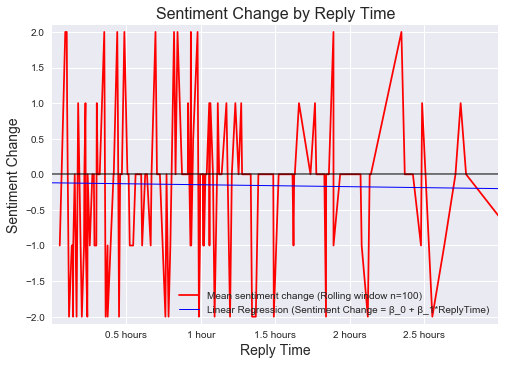

In [93]:
df_klm_luggage2 = df_klm_luggage.sort_values(by='replyTime', ascending=True)#.rolling(2).mean()
df_klm_luggage2 = df_klm_luggage2.set_index('replyTime')

df_klm_luggage2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)')

lr = LinearRegression()
lr.fit(df_klm_luggage[['replyTime']], df_klm_luggage[['sentChange']])
x1 = 0
y1 = lr.intercept_[0]
x2 = 10800
y2 = lr.intercept_[0] + lr.coef_[0][0]*x2
plt.plot([x1, x2], [y1, y2], 'k-', lw=1, label="Linear Regression (Sentiment Change = β_0 + β_1*ReplyTime)", color='blue')

plt.xlim(0,10800)
plt.ylim(-2.1,2.1)
plt.xticks([1800, 3600, 5400, 7200, 9000], ["0.5 hours", "1 hour", "1.5 hours", "2 hours", "2.5 hours"])
plt.ylabel('Sentiment Change', size=14)
plt.xlabel('Reply Time', size=14)
plt.title("Sentiment Change by Reply Time", size=16)
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower right')
plt.savefig('SentimentChange_by_ReplyTime.png', dpi=300)
plt.show()

In [90]:
df_ba_luggage = sentiment_vs_replytime2(["British_Airways"],["18332190"], df)
#df_klm1['replyTime'].describe()
df_ba_luggage['replyTime'] = df_ba_luggage['replyTime'].astype('int64')
df_ba_luggage['sentChange'] = df_ba_luggage['sentChange'].astype('float64')

[British_Airways]
(68941, 14)
errors: 1916
total luggage: 786
total: 8162


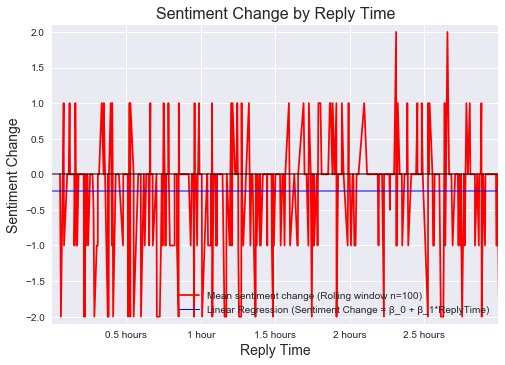

In [94]:
df_ba_luggage2 = df_ba_luggage.sort_values(by='replyTime', ascending=True)#.rolling(2).mean()
df_ba_luggage2 = df_ba_luggage2.set_index('replyTime')

df_ba_luggage2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)')

lr = LinearRegression()
lr.fit(df_ba_luggage[['replyTime']], df_ba_luggage[['sentChange']])
x1 = 0
y1 = lr.intercept_[0]
x2 = 10800
y2 = lr.intercept_[0] + lr.coef_[0][0]*x2
plt.plot([x1, x2], [y1, y2], 'k-', lw=1, label="Linear Regression (Sentiment Change = β_0 + β_1*ReplyTime)", color='blue')

plt.xlim(0,10800)
plt.ylim(-2.1,2.1)
plt.xticks([1800, 3600, 5400, 7200, 9000], ["0.5 hours", "1 hour", "1.5 hours", "2 hours", "2.5 hours"])
plt.ylabel('Sentiment Change', size=14)
plt.xlabel('Reply Time', size=14)
plt.title("Sentiment Change by Reply Time", size=16)
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower right')
plt.savefig('SentimentChange_by_ReplyTime.png', dpi=300)
plt.show()

In [23]:
df_all_luggage = sentiment_vs_replytime2(["KLM", "AirFrance", "British_Airways", "AmericanAir", "Lufthansa", 
"AirBerlin", "AirBerlin assist", "easyJet", "RyanAir", "SingaporeAir", 
"Qantas", "EtihadAirways", "VirginAtlantic"],["56377143", "106062176", "18332190", "22536055", 
"124476322", "26223583", "2182373406", "38676903", 
"1542862735", "253340062", "218730857", "45621423", "20626359"]
, df)
#df_klm1['replyTime'].describe()
df_all_luggage['replyTime'] = df_all_luggage['replyTime'].astype('int64')
df_all_luggage['sentChange'] = df_all_luggage['sentChange'].astype('float64')
df_all_luggage = df_all_luggage.dropna()

errors: 13162
total luggage: 4497
total: 45856


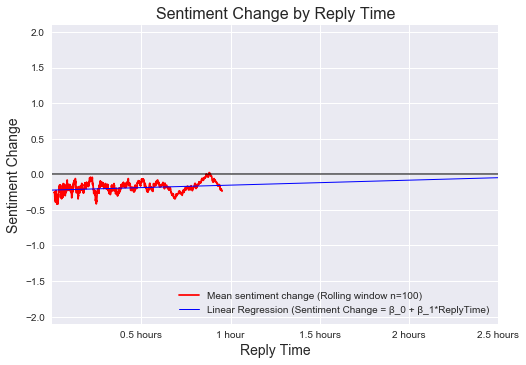

In [21]:
df_all_luggage = df_all_luggage[df_all_luggage['replyTime']<3600]
df_all_luggage2 = df_all_luggage.sort_values(by='replyTime', ascending=True).rolling(100).mean()
df_all_luggage2 = df_all_luggage2.set_index('replyTime')

df_all_luggage2['sentChange'].plot(kind='line', color='red', label='Mean sentiment change (Rolling window n=100)')

lr = LinearRegression()
lr.fit(df_all_luggage[['replyTime']], df_all_luggage[['sentChange']])
x1 = 0
y1 = lr.intercept_[0]
x2 = 10800
y2 = lr.intercept_[0] + lr.coef_[0][0]*x2
plt.plot([x1, x2], [y1, y2], 'k-', lw=1, label="Linear Regression (Sentiment Change = β_0 + β_1*ReplyTime)", color='blue')

plt.xlim(0,3600)
plt.ylim(-2.1,2.1)
plt.xticks([1800, 3600, 5400, 7200, 9000], ["0.5 hours", "1 hour", "1.5 hours", "2 hours", "2.5 hours"])
plt.ylabel('Sentiment Change', size=14)
plt.xlabel('Reply Time', size=14)
plt.title("Sentiment Change by Reply Time", size=16)
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower right')
plt.savefig('SentimentChange_by_ReplyTime.png', dpi=300)
plt.show()

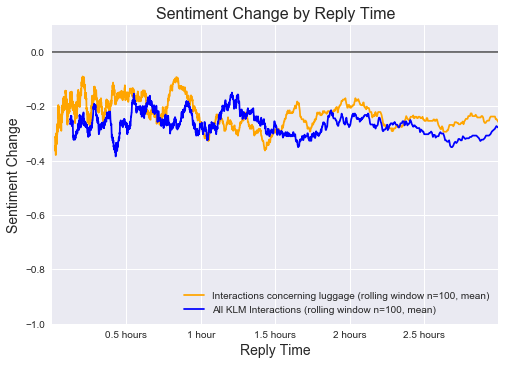

In [39]:
#df_all_luggage = df_all_luggage[df_all_luggage['replyTime']<3600]
df_all_luggage2 = df_all_luggage.sort_values(by='replyTime', ascending=True).rolling(200).mean()
df_all_luggage2 = df_all_luggage2.set_index('replyTime')

df_all_luggage2['sentChange'].plot(kind='line', color='orange', label='Interactions concerning luggage (rolling window n=100, mean)')

df_klm2 = df_klm1.sort_values(by='replyTime', ascending=True).rolling(200).mean()
df_klm2 = df_klm2.set_index('replyTime')

df_klm2['sentChange'].plot(kind='line', color='blue', label='All KLM Interactions (rolling window n=100, mean)')

lr = LinearRegression()
lr.fit(df_klm1[['replyTime']], df_klm1[['sentChange']])
x1 = 0
y1 = lr.intercept_[0]
x2 = 10800
y2 = lr.intercept_[0] + lr.coef_[0][0]*x2
#plt.plot([x1, x2], [y1, y2], 'k-', lw=1.5, label="Linear Regression (Sentiment Change = β_0 + β_1*ReplyTime)", color='lightblue')

plt.xlim(0,10800)
plt.ylim(-1,0.1)
plt.xticks([1800, 3600, 5400, 7200, 9000], ["0.5 hours", "1 hour", "1.5 hours", "2 hours", "2.5 hours"])
plt.ylabel('Sentiment Change', size=14)
plt.xlabel('Reply Time', size=14)
plt.title("Sentiment Change by Reply Time", size=16)
plt.axhline(y=0, color='black', alpha=0.6)
plt.legend(loc='lower right')
plt.savefig('SentimentChange_by_ReplyTime.svg', dpi=300)
plt.show()